# Model 1

We implement a multilater perceptron with 3 dense layers, batch normalization layers as well as dropout layers. We also optimized gradient descent using Adam. We did not consider CNNs or RNNs, since we believe would not be suitable for this classification task due to the lack of temporal and time series data.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import plotly.express as px

df = pd.read_csv("hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv")
top20 = df['track_genre'].value_counts(ascending=False)[:20].index
df = df[df['track_genre'].isin(top20)]
df['track_genre'] = LabelEncoder().fit_transform(df['track_genre'])

# dropped 'explicit' since it is a sparse feature with many zero values (majority class is 'false')
X = df.select_dtypes(exclude = 'object').drop(['Unnamed: 0', 'track_genre', 'explicit'], axis = 1)
y = df['track_genre']

print(X.shape)
print(y.shape)

(20000, 14)
(20000,)


In [ ]:
df['track_genre'].unique()

array(['acoustic', 'kids', 'latin', 'latino', 'malay', 'mandopop',
       'metal', 'metalcore', 'minimal-techno', 'mpb', 'new-age', 'opera',
       'pagode', 'party', 'piano', 'pop-film', 'pop', 'power-pop',
       'progressive-house', 'punk-rock'], dtype=object)

In [ ]:
df['track_genre'].value_counts(ascending=False)[60:]

,count
track_genre,


In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

X = ((X - np.min(X, axis = 0)) / (np.max(X, axis = 0) - np.min(X, axis = 0)))
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=2000, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=1000, random_state=123, stratify=y_temp)


# Convert to categorical (onehot encoding matrices)
y_train = to_categorical(y_train, num_classes=20)
y_valid = to_categorical(y_valid, num_classes=20)
y_test = to_categorical(y_test, num_classes=20)


# # optional to free up some memory by deleting non-used arrays:
del X_temp, y_temp, X, y

In [ ]:
import tensorflow as tf
from keras.layers import Dense, Activation, Dropout, Conv1D, LSTM, MaxPooling1D
from keras.layers import Flatten, Conv2D, MaxPooling2D, GRU, BatchNormalization
from keras.layers import Bidirectional, Reshape, Input, AveragePooling2D, SpatialDropout2D, Permute, Lambda
from keras.models import Sequential, load_model, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.losses import CategoricalCrossentropy
from keras.regularizers import L1L2, L2

class SequentialModel:
    def __init__(self):
        self.model = Sequential()

    def load_model(self, filepath):
        print('[Model] Loading model from file %s' % filepath)
        self.model = load_model(filepath)

    def build_model(self, config):
        """ Virtual Function """
        return

    def train(self, x, y, x_val, y_val, config):
        """ Virtual Function """
        return

    def evaluate(self, x_test, y_test, verbose=1):
        return self.model.evaluate(x_test,  y_test, verbose=verbose)

    def predict(self, x_test, verbose=1):
        return self.model.predict(x_test, verbose=verbose)

class Model(SequentialModel):
    def __init__(self):
        super(Model, self).__init__()

    def build_model(self, config):
        model = self.model

        input_shape = config["input_shape"]
        lr = config.get('lr', 0.001)
        decay = config.get("decay", 0.01)

        model.add(Dense(64, kernel_regularizer=L2(l2=0.01), input_shape=input_shape, activation='elu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))

        model.add(Dense(32, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))

        model.add(Dense(16, activation='relu'))
        model.add(BatchNormalization(axis=1))
        model.add(Dropout(0.5))

        model.add(Dense(20, kernel_regularizer=L2(l2=0.01), activation='softmax'))
        optimizer = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999,
                         amsgrad=False, epsilon=1e-8, decay=decay)
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        print(model.summary())
        print("Model compiled.")

    def train(self, x, y, x_val, y_val, config):
        history = self.model.fit(x, y, epochs=config['epochs'], batch_size=config['batch_size'],
                                 validation_data=(x_val, y_val), shuffle=True,
                                )

        return history

In [ ]:
input_shape = X_train.shape[1:]

model = Model()

config = {
    'input_shape': input_shape,
    'epochs': 60,
    'dropout': 0.5,
    'batch_size': 32,
    'lr': 0.001
}
model.build_model(config)
history = model.train(X_train, y_train, X_valid, y_valid, config)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 64)                  │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 20)                  │             340 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,356 (17.02 KB)

 Trainable params: 4,132 (16.14 KB)

 Non-trainable params: 224 (896.00 B)

None
Model compiled.
Epoch 1/60
532/532 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.0900 - loss: 3.6445 - val_accuracy: 0.2990 - val_loss: 2.6386
Epoch 2/60
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2091 - loss: 2.7458 - val_accuracy: 0.3400 - val_loss: 2.2976
Epoch 3/60
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2594 - loss: 2.5093 - val_accuracy: 0.3790 - val_loss: 2.1368
Epoch 4/60
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2795 - loss: 2.3631 - val_accuracy: 0.3980 - val_loss: 2.0246
Epoch 5/60
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2987 - loss: 2.2899 - val_accuracy: 0.4320 - val_loss: 1.9614
Epoch 6/60
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3040 - loss: 2.2554 - val_accuracy: 0.3870 - val_loss: 1.9599
Epoch 7/60
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3185 - loss: 2.2114 - val_accuracy: 0.4280 - val_loss: 1.8792
Epoch 8/60
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3225 - loss: 2.18

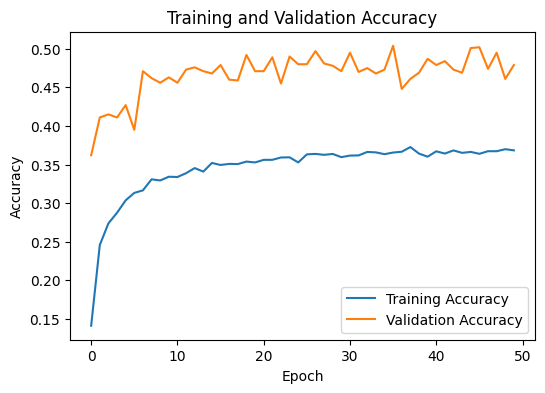

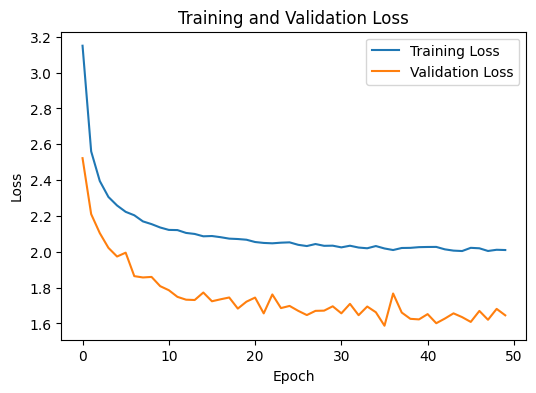

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4754 - loss: 1.6882


[1.6612632274627686, 0.47450000047683716]

We achieve a training accuracy of 48.66% and a validation accuracy of 49.1%.

# Model 2


We train a different model with dense layers of smaller units, since the feature space is not that large.

In [ ]:

class Model2(SequentialModel):
    def __init__(self):
        super(Model2, self).__init__()

    def build_model(self, config):
        model = self.model

        input_shape = config["input_shape"]
        lr = config.get('lr', 0.001)
        decay = config.get("decay", 0.01)

        model.add(Dense(64, kernel_regularizer=L1L2(l1=0, l2=0.01), input_shape=input_shape, activation='elu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))

        model.add(Dense(128, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))

        model.add(Dense(32, activation='relu'))
        model.add(BatchNormalization(axis=1))
        model.add(Dropout(0.3))

        model.add(Dense(16, activation='relu'))
        model.add(BatchNormalization(axis=1))
        model.add(Dropout(0.3))

        model.add(Dense(20, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='softmax'))
        optimizer = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999,
                         amsgrad=False, epsilon=1e-8, decay=decay)
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        print(model.summary())
        print("Model compiled.")

    def train(self, x, y, x_val, y_val, config):
        history = self.model.fit(x, y, epochs=config['epochs'], batch_size=config['batch_size'],
                                 validation_data=(x_val, y_val), shuffle=True,
                                )

        return history

In [ ]:
input_shape = X_train.shape[1:]
config = {
    'input_shape': input_shape,
    'epochs': 100,
    'dropout': 0.5,
    'batch_size': 32,
    'lr': 0.001
}
model = Model2()
model.build_model(config)
history = model.train(X_train, y_train, X_valid, y_valid, config)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 64)                  │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 20)                  │             340 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,236 (59.52 KB)

 Trainable params: 14,756 (57.64 KB)

 Non-trainable params: 480 (1.88 KB)

None
Model compiled.
Epoch 1/100
532/532 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.1145 - loss: 3.4053 - val_accuracy: 0.3700 - val_loss: 2.3807
Epoch 2/100
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2630 - loss: 2.5493 - val_accuracy: 0.4120 - val_loss: 2.0706
Epoch 3/100
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3215 - loss: 2.2957 - val_accuracy: 0.4410 - val_loss: 1.9129
Epoch 4/100
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3352 - loss: 2.1777 - val_accuracy: 0.4420 - val_loss: 1.8491
Epoch 5/100
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3567 - loss: 2.1101 - val_accuracy: 0.4370 - val_loss: 1.8559
Epoch 6/100
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3625 - loss: 2.0872 - val_accuracy: 0.4920 - val_loss: 1.7138
Epoch 7/100
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3779 - loss: 2.0298 - val_accuracy: 0.4210 - val_loss: 1.8296
Epoch 8/100
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3799 - lo

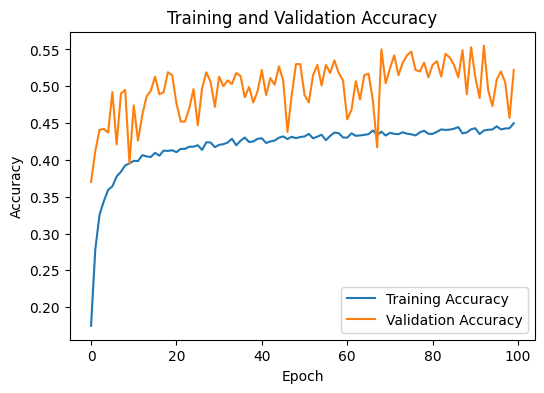

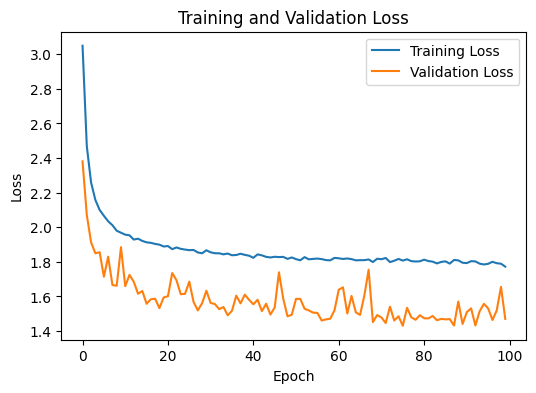

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5214 - loss: 1.5394


[1.527504563331604, 0.5059999823570251]

# Tuning Hyperparameters using KerasTuner

To optimize model performance, we tune hyperparameters such as dropout rate and learning rate using KerasTuner.

In [ ]:
import keras_tuner as kt

def build_model(hp):
  model = Sequential()
  input_shape = config["input_shape"]
  lr = hp.Float('lr', min_value=1e-5, max_value=1e-2, sampling='LOG', default=0.001)
  decay = config.get("decay", 0.01)
  dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.6, step=0.1)

  model.add(Dense(64, kernel_regularizer=L1L2(l1=0, l2=0.01), input_shape=input_shape, activation='elu'))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_rate))

  model.add(Dense(128, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_rate))

  model.add(Dense(32, activation='relu'))
  model.add(BatchNormalization(axis=1))
  model.add(Dropout(dropout_rate))

  model.add(Dense(16, activation='relu'))
  model.add(BatchNormalization(axis=1))
  model.add(Dropout(dropout_rate))

  model.add(Dense(20, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='softmax'))
  optimizer = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999,
                    amsgrad=False, epsilon=1e-8, decay=decay)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model


tuner = kt.Hyperband(
    build_model,  # Model-building function
    objective='val_accuracy',  # Objective metric to maximize
    max_epochs=50,  # Maximum number of epochs per trial
    factor=3, directory='./new_directory'
)

tuner.search(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid))

best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Get the best model based on the best hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]

# You can also access the history of the training process
history = tuner.oracle.get_trial(tuner.oracle.get_best_trials()[0].trial_id).metrics

# Print out the training and validation accuracy
print(f"Best Hyperparameters: {best_hyperparameters.values}")
# print(f"Training Accuracy: {history['accuracy']}")
# print(f"Validation Accuracy: {history['val_accuracy']}")

Reloading Tuner from ./new_directory/untitled_project/tuner0.json
Best Hyperparameters: {'lr': 0.0020160217534425325, 'dropout_rate': 0.2, 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 3, 'tuner/round': 3, 'tuner/trial_id': '0047'}


In [ ]:
accuracy_history = history.get_history('accuracy')
val_accuracy_history = history.get_history('val_accuracy')
print(f"Training Accuracy: {accuracy_history}")
print(f"Validation Accuracy: {val_accuracy_history}")

Training Accuracy: [MetricObservation(value=[0.4601176381111145], step=23)]
Validation Accuracy: [MetricObservation(value=[0.5619999766349792], step=23)]


In [ ]:
best_model.evaluate(X_test, y_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5453 - loss: 1.4812  


[1.4651914834976196, 0.5350000262260437]

After tuning our hyperparameters, our model yields a training accuracy of 54.53% and a validation accuracy of 53.5%.